In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [3]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [5]:
# Lets just try using everything we've got and throwing it without much thought into a Random Forest
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [6]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
12
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


In [7]:
# Convert ID and interest rate to numeric
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 
          'revol_util', 'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [8]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Remove two summary rows at the end that don't actually contain any data
y2015 = y2015[:-2]

In [10]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0
5,68506798.0,73396623.0,23000.0,23000.0,23000.0,8.49,471.77,64000.0,18.28,0.0,...,0,0,0,0,0,1,0,0,0,0
6,68566886.0,73456723.0,29900.0,29900.0,29900.0,12.88,678.49,65000.0,21.77,0.0,...,0,0,0,0,0,1,0,0,0,0
7,68577849.0,73467703.0,18000.0,18000.0,18000.0,11.99,400.31,112000.0,8.68,0.0,...,0,0,0,0,0,1,0,0,0,0
8,66310712.0,71035433.0,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,...,0,0,0,0,0,1,0,0,0,0
9,68476807.0,73366655.0,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,...,0,0,0,0,0,1,0,0,0,0


In [28]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv = 10)

array([ 0.9801952 ,  0.98026644,  0.98157251,  0.98159626,  0.9701971 ,
        0.97703633,  0.95098435,  0.980313  ,  0.98000332,  0.98052534])

# Drill

In [29]:
# Lets run a PCA

# Standardize the data
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [14]:
# Perform a eigendecomposition to obtain the eigenvectors and eigenvalues
cov_mat = np.cov(X_std.T)
print('Numpy Covariance Matrix: \n%s' %cov_mat)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors: \n%s' %eig_vecs)
print('Eigenvalues: \n%s' %eig_vals)

Numpy Covariance Matrix: 
[[  1.00000237e+00   9.97542503e-01  -8.28800909e-03 ...,   3.16988700e-02
    1.52046554e-02   2.45114833e-02]
 [  9.97542503e-01   1.00000237e+00  -8.61952110e-03 ...,   3.20023212e-02
    1.53795433e-02   2.47610695e-02]
 [ -8.28800909e-03  -8.61952110e-03   1.00000237e+00 ...,   8.35951079e-03
    7.08866573e-03   1.43504240e-02]
 ..., 
 [  3.16988700e-02   3.20023212e-02   8.35951079e-03 ...,   1.00000237e+00
   -3.12145102e-04  -5.16540667e-04]
 [  1.52046554e-02   1.53795433e-02   7.08866573e-03 ...,  -3.12145102e-04
    1.00000237e+00  -2.39751698e-04]
 [  2.45114833e-02   2.47610695e-02   1.43504240e-02 ...,  -5.16540667e-04
   -2.39751698e-04   1.00000237e+00]]
Eigenvectors: 
[[ -1.20351960e-02 +0.00000000e+00j  -6.69705134e-02 +0.00000000e+00j
   -1.54013896e-01 +0.00000000e+00j ...,   9.12168571e-11 +3.09212238e-11j
    0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j]
 [ -1.21209540e-02 +0.00000000e+00j  -6.69837193e-02 +0.0000000

In [15]:
# Sort the eigenvalues in descending order

# make a list of tuples (eig_vals, eig_vecs)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

# sort the tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted
print('Eigenvalues in Descending Order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in Descending Order:
10.7502311391
6.17352416772
5.97212514331
4.73791550606
3.77645496405
3.2137800385
3.14726244227
2.92405966701
2.62657166913
2.58753219657
2.32963927248
2.2449639502
2.11795045977
2.06296070662
2.04311155277
2.02274054992
2.01668566126
2.01145727263
2.00561436789
2.00122727838
1.99578056047
1.96431841217
1.94592056945
1.8917817933
1.77417612393
1.6687454006
1.64983346945
1.53506668001
1.502894291
1.47647045451
1.44527086934
1.42962479683
1.40963439331
1.39848479471
1.38035344204
1.37261806488
1.36252144121
1.35534908629
1.35089743077
1.33003867385
1.30991067146
1.30019333591
1.29710697255
1.27905951514
1.26918282197
1.26306935599
1.24968036917
1.24444865332
1.23108084849
1.21691019565
1.21365820972
1.19247017129
1.1844146922
1.16992688109
1.16196529081
1.15883969399
1.15255655261
1.12934839367
1.1243266888
1.113066405
1.10966824802
1.09663290661
1.09307871272
1.09127962058
1.08459737041
1.08066455279
1.07261308369
1.07157370291
1.067096021
1.06069568016

/anaconda/lib/python3.6/site-packages/matplotlib/patches.py:693: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


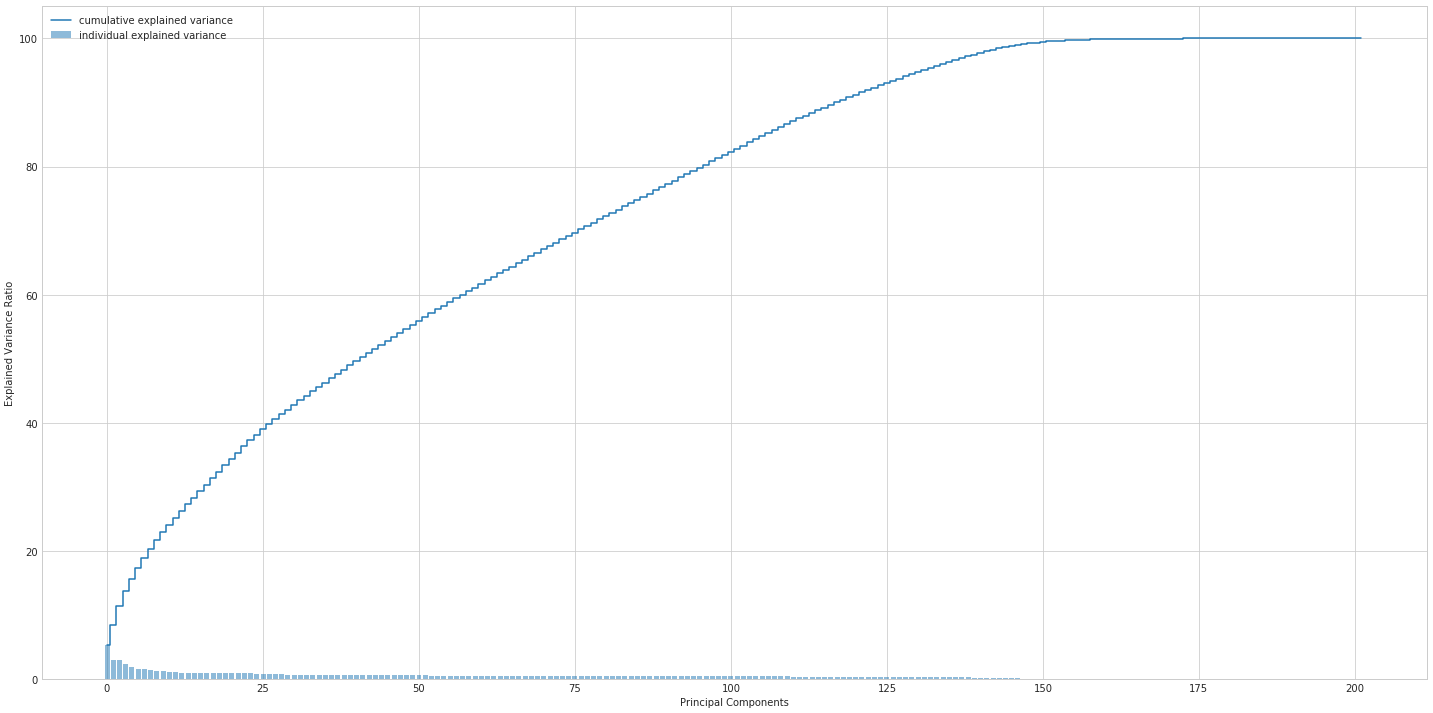

In [16]:
# Explained variance
tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot the explained variance
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(20,10))
    plt.bar(range(202), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(202), cum_var_exp, where='mid', label= 'cumulative explained variance')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Components')
    plt.legend(loc='best')
    plt.tight_layout()

In [19]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components = 125)
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [35]:
new_2015 = pd.DataFrame()

for i in range(0, 125, 1):
    new_2015[i] = Y_sklearn[:, i]

new_2015['loan_status'] = y2015['loan_status']

In [36]:
new_2015.head()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,loan_status
0,3.868644,2.668775,-3.086697,2.930536,-1.746125,2.063760,0.973402,-1.129535,1.054473,-3.257489,...,-2.562999,0.313212,-0.504898,0.456502,-0.446908,-0.308461,-0.381501,-0.162220,0.184368,Current
1,-3.267362,0.152533,-2.274610,3.180889,-0.659786,2.041262,1.094392,-1.248141,0.797530,0.831057,...,0.066887,-0.341045,-0.122532,0.120099,-0.035096,-0.136992,-0.012975,-0.139262,0.575479,Current
2,2.572077,-4.148447,1.679485,3.545188,0.309595,-0.753363,3.918163,-1.894129,-0.707937,0.368348,...,-0.133848,0.104657,0.677509,0.167790,-1.312357,0.864485,-1.643548,0.164235,0.120865,Fully Paid
3,4.195052,0.558517,-2.972911,2.319266,-1.116607,-1.666557,3.166856,-1.103634,0.739108,-1.507978,...,-0.003774,-0.255644,-0.099866,-0.515692,0.625296,-0.150654,0.420301,-0.214948,0.233579,Current
4,-0.335750,4.036621,5.306483,-3.934103,1.072121,2.658542,3.488618,-3.060300,-1.875054,-0.272229,...,-2.909608,-1.180212,0.443169,-2.117871,1.798594,-0.748064,-1.477129,1.621126,-1.489966,Fully Paid


In [37]:
# Run the random forest now that the PCA has reduced the number of variables; check score

rfc = ensemble.RandomForestClassifier()
X = new_2015.drop('loan_status', 1)
Y = new_2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv = 10)

array([ 0.95310014,  0.95336135,  0.9548574 ,  0.9555698 ,  0.93493232,
        0.94682973,  0.94946449,  0.9503669 ,  0.94288361,  0.94969838])